## Train the UNET model

In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 2.0 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 66.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 75.3 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 67.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 64.8 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 69.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 96.6 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 7.4 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 6.3 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 8.1 MB/s  eta 0:00:01
     |████████████████████████████████|

In [1]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys
import numpy as np
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
             transforms.ToTensor(),
             ])
mask_transform = transforms.Compose([transforms.ToTensor()])

In [3]:
#Ref: https://github.com/fhaghighi/SemanticGenesis
def image_in_painting(x):
    img_rows, img_cols, img_deps = x.shape
    block_noise_size_x = random.randint(img_rows // 6, img_rows // 3)
    block_noise_size_y = random.randint(img_cols // 6, img_cols // 3)
    block_noise_size_z = random.randint(img_deps // 6, img_deps // 3)
    noise_x = random.randint(3, img_rows - block_noise_size_x - 3)
    noise_y = random.randint(3, img_cols - block_noise_size_y - 3)
    #noise_z = random.randint(3, img_deps - block_noise_size_z - 3)
    noise_z = 0
    block_noise_size_z = 3
    x[noise_x:noise_x + block_noise_size_x,
    noise_y:noise_y + block_noise_size_y,
    noise_z:noise_z + block_noise_size_z] = np.random.rand(block_noise_size_x,
                                                           block_noise_size_y,
                                                          block_noise_size_z, ) * 1.0
    return x

In [26]:
train_image_files = os.listdir('/app/data/unet/train/images/')
train_mask_files = [im_file.replace('img', 'mask') for im_file in train_image_files]

val_image_files = os.listdir('/app/data/unet/val/images/')
val_mask_files = [im_file.replace('img', 'mask') for im_file in val_image_files]

test_image_files = os.listdir('/app/unet_test_from_fullsize_image/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]
print("Train files: {}, val files: {}, test files: {}".format(len(train_image_files), len(val_image_files), len(test_image_files)))

Train files: 581, val files: 1631, test files: 380


In [5]:
import cv2
from PIL import Image
class NoduleDataset(Dataset):
    def __init__(self, root_dir, image_paths, mask_paths, transforms=None, image_shape=(128,128), augment=False):
        super().__init__()
        self.augment = augment
        self.image_shape = image_shape
        self.batch_size = len(image_paths)
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(self.root_dir + 'images/' + self.image_paths[index])
        image = cv2.resize(image, (64, 64))
        r = np.random.random()
        if self.augment:
            if r <= 0.33:
                image = image_in_painting(image)
            else: # no transformation except for gaussion blur done in elastic
                image = image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        
        mask = cv2.imread(self.root_dir + 'masks/' + self.mask_paths[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (64, 64))
        (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        if self.transforms:
            image = self.transforms(image)
        mask = mask_transform(mask)
        #convert from Boolean to int (0,1)
        mask = mask.to(torch.uint8)
        mask = (mask > 0).float()
        return image, mask#, self.image_paths[index], self.mask_paths[index]
            

batch_size = 16
num_workers = 0

nodule_data_train = NoduleDataset('/app/data/unet/train/',train_image_files, train_mask_files, transforms=train_transform, augment=True)
train_loader = DataLoader(nodule_data_train, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers)

nodule_data_val = NoduleDataset('/app/data/unet/val/',val_image_files, val_mask_files, transforms=val_transform, augment=False)
val_loader = DataLoader(nodule_data_val, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers, drop_last=True)
print("Number of train files are {} and test files are {}".format(len(train_mask_files), len(val_mask_files)))

Number of train files are 581 and test files are 1631


In [6]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [7]:
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


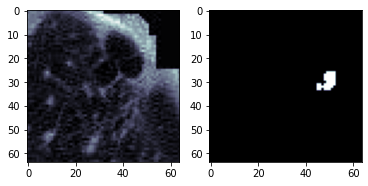

In [8]:
#images.shape
f,a = plt.subplots(1,2)
a[0].imshow(images[2][0,:,:], 'bone')
#images.shape
a[1].imshow(labels[2][0,:,:], 'bone')

### Define the model

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [10]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.8.0a0+52ea372
Number of GPUs = 0


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
if torch.cuda.device_count() > 0:
    model = torch.nn.parallel.DataParallel(model, device_ids=[0, 1]).cuda()

In [12]:
if torch.cuda.device_count() > 0:
    device = torch.device("cuda")
else:
    device = 'cpu'

In [13]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
             Block-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,928
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [14]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [15]:
# IoU only for the images which has nodules in ground truth
def iou_coeff(y_true, y_pred):
    smooth = 0.0001
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
        return torch.mean((torch.sum(y_true * y_pred, dim = [1,2]) + smooth) / 
                          (torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) 
                           - torch.sum(y_true * y_pred, dim = [1,2]) + smooth), dim=[0])

#### Configure metrics logging in tensorboard

In [16]:
from torch.utils.tensorboard import SummaryWriter

In [17]:
def get_next_rundir():
    dirs = os.listdir('runs')
    dirs = [d for d in dirs if d.find('unet_lidc_') > 0]
    if len(dirs) > 0:
        print(dirs)
        idx = np.sort([int(d.split('_')[2]) for d in dirs])[-1]
        newdirname = 'runs/unet_lidc_{}'.format(idx+1)
    else:
        newdirname = 'runs/unet_lidc_{}'.format(0)
    return newdirname

## Run training

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(train_epochs):
    
    num_epochs = train_epochs
    
    
    criterion  = nn.BCEWithLogitsLoss()
    #optimizer  = torch.optim.Adam(model.parameters(),0.0001)
    #TODO: fix this later
    # use LR params from Yolo training
#     learning_rate = 0.00654
#     optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.00042, momentum=0.47849)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9, weight_decay=0.0, nesterov=False)
    
    
    rundir = get_next_rundir()
    writer = SummaryWriter(rundir)
    
    train_loss = []
    val_loss   = []
    best_dice = 0
    best_loss = 1
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        running_loss = 0.0
        batch_dice_score = []
        epoch_dice_score = []
        start = time.time()
#         lr = scheduler._last_lr
        writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch)
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss = loss.item()
            running_loss += curr_loss
            epoch_loss += curr_loss

            # begin: DICE score
            #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
            mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            if mask_pre.ndim == 2:
                mask_pre = mask_pre[None,:,:]
            #print('labels shape = ', labels.shape, 'mask shape =', mask_pre.shape, 'ndim=', mask_pre.ndim)
            
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            batch_dice_score.append(score)
            epoch_dice_score.append(score)
            # end: DICE score

            if i % 100 == 99: # every 10 minibatch
                writer.add_scalar('training loss', running_loss/100, epoch * len(train_loader) + i)
                writer.add_scalar('training dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                running_loss = 0.0
                batch_dice_score = []

        epoch_loss /= i+1
        train_loss.append(epoch_loss)
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))

        end = time.time()
        print(f"Epoch {epoch} trained with loss: {epoch_loss}, and dice score {epoch_dice_score}. The running time is {end-start}.")

        model.eval()
        running_loss = 0.0
        epoch_loss = 0.0
        running_score = 0.0
        start = time.time()
        batch_dice_score = []
        epoch_dice_score = []
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                curr_loss = loss.item()
                running_loss += curr_loss
                epoch_loss += curr_loss

                # begin: DICE score
                #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
                mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
                outputs = np.squeeze(mask_pre_prob).detach().cpu()
                mask_pre = np.where(outputs>0.5, 1,0)
                mask_pre = torch.from_numpy(mask_pre)
                #print('labels shape = ', labels.shape, 'mask shape =', mask_pre.shape)
                score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
                batch_dice_score.append(score)
                epoch_dice_score.append(score)
                # end: DICE score
#                 if i % 100 == 99: # every 10 minibatch
#                     writer.add_scalar('eval loss', running_loss/100, epoch * len(val_loader) + i)
#                     writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
#                     running_loss = 0.0
#                     batch_dice_score = []
        writer.add_scalar('eval loss', running_loss/len(batch_dice_score), epoch)
        writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch)
        running_loss = 0.0
        batch_dice_score = []
        
        epoch_loss /= i+1
        #running_score /= i+1
        val_loss.append(epoch_loss)
        end = time.time()
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))
        print(f"Epoch {epoch} evaluated with loss: {epoch_loss}, and dice score: {epoch_dice_score}. The running time is {end-start}.")
        #update scheduler step
        #scheduler.step(epoch_loss)
        
        #if running_loss == min(val_loss):
        PATH = f'{rundir}/Epoch{epoch}.pth'
        torch.save(model.state_dict(),PATH)
        print('Last model saved at epoch:', epoch)
        if epoch_dice_score > best_dice:
            best_dice = epoch_dice_score
            PATH = f'{rundir}/best_{epoch}.pth'
            torch.save(model.state_dict(),PATH)
            print('Best model saved at epoch:', epoch)

    print("Training is completed.")

In [44]:
train(1)

Epoch 0 trained with loss: 0.734471633627608, and dice score 0.02221321500837803. The running time is 63.03806257247925.
Epoch 0 evaluated with loss: 0.6747934571420303, and dice score: 0.03210202977061272. The running time is 41.198782205581665.
Last model saved at epoch: 0
Best model saved at epoch: 0
Training is completed.


### Test the model be trained

In [27]:
import cv2
from PIL import Image
class NoduleDataset(Dataset):
    def __init__(self, root_dir, image_paths, mask_paths, transforms=None, image_shape=(128,128), augment=False):
        super().__init__()
        self.augment = augment
        self.image_shape = image_shape
        self.batch_size = len(image_paths)
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(self.root_dir + 'images/' + self.image_paths[index])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(self.root_dir + 'masks/' + self.mask_paths[index])

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        if self.transforms:
            image = self.transforms(image)
        mask = mask_transform(mask)
        #convert from Boolean to int (0,1)
        mask = mask.to(torch.uint8)
        mask = (mask > 0).float()
        return image, mask
            

batch_size = 16
num_workers = 0

nodule_data_test = NoduleDataset('/app/unet_test_from_fullsize_image/test/',test_image_files, test_mask_files, transforms=val_transform, augment=False)
test_loader = DataLoader(nodule_data_test, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers)
print("Number of test files are {}".format(len(nodule_data_test)))

Number of test files are 380


In [28]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    scores = []
    batch_dice_score = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            score_map = {'id': i, 'dice': score.item()}
            scores.append(score_map)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    print("dice score: {}".format(final_score))
    return final_score, least_dice, least_label, least_pre, scores

In [29]:
if torch.cuda.device_count() > 0:
    device = torch.device("cuda")
else:
    device = 'cpu'
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
if torch.cuda.device_count() > 0:
    seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
seg_model = torch.nn.parallel.DataParallel(seg_model)
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth', map_location='cpu'))

seg_model.eval()
final_score, least_dice, least_label, least_pre, scores  = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}".format(final_score))

1it [00:00,  2.45it/s]

Accumulated dice coeff 0.816933810710907


24it [00:08,  2.74it/s]

dice score: 0.802039623260498
Final test dice score = 0.802039623260498


In [30]:
if torch.cuda.device_count() > 0:
    device = torch.device("cuda")
else:
    device = 'cpu'
def get_fpfn(model, loader):
    model.eval()
    fn = 0
    fp = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            for idx in range(labels.shape[0]):
                total += 1
                gt_pos = (torch.sum(labels[idx,:], dim=[1,2]) > 0)
                pred_pos = (torch.sum(mask_pre[idx], dim=[0,1]) > 0)                    
                if (not gt_pos) and ( pred_pos):
                    fp += 1
                    y_true.append(0)
                    y_pred.append(1)
                elif (gt_pos) and (not pred_pos):
                    fn += 1
                    y_true.append(1)
                    y_pred.append(0)
                elif gt_pos and pred_pos:
                    y_true.append(1)
                    y_pred.append(1)
                else:
                    y_true.append(0)
                    y_pred.append(0)
    return fp, fn, total, y_true, y_pred

In [31]:
if torch.cuda.device_count() > 0:
    device = torch.device("cuda")
else:
    device = 'cpu'
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
if torch.cuda.device_count() > 0:
    seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
seg_model = torch.nn.parallel.DataParallel(seg_model)
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth', map_location='cpu'))

seg_model.eval()
fp, fn, total, y_true, y_pred = get_fpfn(seg_model, test_loader)

24it [00:08,  2.76it/s]


In [32]:
from sklearn.metrics import classification_report
target_names = ['nodule','no nodule']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      nodule       0.90      0.89      0.89        88
   no nodule       0.97      0.97      0.97       292

    accuracy                           0.95       380
   macro avg       0.93      0.93      0.93       380
weighted avg       0.95      0.95      0.95       380



In [33]:
def sample_false_positives(model, loader):
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            #score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            for idx in range(labels.shape[0]):
                gt_pos = (torch.sum(labels[idx,:], dim=[1,2]) > 0)
                pred_pos = (torch.sum(mask_pre[idx], dim=[0,1]) > 0)
                if ( not gt_pos) and ( pred_pos):
                    f = plt.figure(figsize=(6, 8))
                    ax0 = f.add_subplot(1,3,1)
                    ax0.imshow(inputs[idx,0].detach().cpu(), 'bone')
                    ax0.set_title('Original image')
                    ax1 = f.add_subplot(1,3,2)
                    ax1.imshow(labels[idx,0].detach().cpu(), 'bone')
                    ax1.set_title('True mask')
                    ax2 = f.add_subplot(1,3,3)
                    ax2.imshow(mask_pre[idx].detach().cpu(), 'bone')
                    ax2.set_title('Predicted mask')
                    break
                    
def sample_false_negatives(model, loader):
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            #score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            for idx in range(labels.shape[0]):
                gt_pos = (torch.sum(labels[idx,:], dim=[1,2]) > 0)
                pred_pos = (torch.sum(mask_pre[idx], dim=[0,1]) > 0)
                if (gt_pos) and ( not pred_pos):
                    f = plt.figure(figsize=(6, 8))
                    ax0 = f.add_subplot(1,3,1)
                    ax0.imshow(inputs[idx,0].detach().cpu(), 'bone')
                    ax0.set_title('Original image')
                    ax1 = f.add_subplot(1,3,2)
                    ax1.imshow(labels[idx,0].detach().cpu(), 'bone')
                    ax1.set_title('True mask')
                    ax2 = f.add_subplot(1,3,3)
                    ax2.imshow(mask_pre[idx].detach().cpu(), 'bone')
                    ax2.set_title('Predicted mask')
                    break

In [ ]:
device = torch.device("cuda")
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
if torch.cuda.device_count() > 0:
    seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
seg_model = torch.nn.parallel.DataParallel(seg_model)
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth', map_location='cpu'))
seg_model.eval()
sample_false_negatives(seg_model, test_loader)

0it [00:00, ?it/s]

In [ ]:
device = torch.device("cuda")
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth'))
seg_model.eval()
sample_false_positives(seg_model, test_loader)

In [150]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    scores = []
    batch_dice_score = []
    batch_iou = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            iou = iou_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            score_map = {'id': i, 'dice': score.item()}
          
            
            scores.append(score_map)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            batch_iou.append(iou)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    final_iou = torch.mean(torch.from_numpy(np.array(batch_iou)))
    print("dice coeff: {}, iou coeff: {}".format(final_score, final_iou))
    return final_score, least_dice, least_label, least_pre, scores, final_iou

In [152]:
device = torch.device("cuda")
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre, scores, final_iou  = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}, iou score = {}".format(final_score, final_iou))

10it [00:00, 46.07it/s]

Accumulated dice coeff 0.8065387606620789


24it [00:00, 47.96it/s]

dice coeff: 0.8015429973602295, iou coeff: 0.7140655517578125
Final test dice score = 0.8015429973602295, iou score = 0.7140655517578125
